In [1]:
%matplotlib inline
from __future__ import division, print_function
import os

In [2]:
!ls

Analyze Motif Dist In Sim.ipynb
compute_imp_score.log
compute_imp_scores.py
compute_imp_scores.pyc
compute_imp_scores.sh
config
dan_basset_keras_port
dinucshuff_motifs_inserted_sigthresh5e-6_sorted_naive_window_around_summit.bed.gz
imp_scores
insert_motifs_in_dincuc_shuff_regions.py
Larger dataset Analyze Motif Dist In Sim-Copy1.ipynb
model_fidelity_results.h5
model_files
motif_hits_sorted_naive_window_around_summit.bed.gz
nonoverlap_dinucshuff_motifs_inserted_sigthresh5e-6_merged_universal_neg_representative_peaks.bed.gz
oneinten_imp_scores
runs_perf-metric-auROC.db
Simulation Assess Model Fidelity.ipynb
sorted_naive_window_around_summit.bed.gz
sorted_naive_window_around_summit.fa.gz
Study Simulated Importance.ipynb
test_set_negatives.bed.gz
test_set_positives.bed.gz
train_dinucshuff_motifs_inserted_sigthresh5e-6_sorted_naive_window_around_summit.bed.gz
train_nonoverlap_dinucshuff_motifs_inserted_sigthresh5e-6_merged_universal_neg_representative_peaks.bed.gz
train_sim_model_from_prein

In [3]:
!zcat test_set_positives.bed.gz | wc -l

18421


In [4]:
import gzip
from collections import namedtuple

MotifHit = namedtuple("MotifHit",['offset', 'motif_id',
                                  'motif_factor', 'motif_seq',
                                  'motif_strand', 'motif_sig'])
def parse_motif_hit(string):
    (offset,motif_id,motif_factor,
     motif_seq,motif_strand,motif_sig) = string.split(",")
    
    offset = int(offset)
    motif_sig = float(motif_sig)
    return MotifHit(offset=offset,
                    motif_id=motif_id,
                    motif_factor=motif_factor,
                    motif_seq=motif_seq,
                    motif_strand=motif_strand,
                    motif_sig=motif_sig)

def parse_sim_file(file_name):
    seqs = []
    motifs_arr = []
    seq_ids = []
    
    for line in gzip.open(file_name):
        line = line.rstrip("\n")
        chrom,start,end,seq_id,seq,motifs = line.split("\t")
        seqs.append(seq)
        motifs_arr.append([parse_motif_hit(x) for x in motifs.split(";")] if len(motifs) > 0 else [])
        seq_ids.append(seq_id)
    return seqs, motifs_arr, seq_ids

original_positives_seqs, original_positives_motifs, original_positives_ids = parse_sim_file("test_set_positives.bed.gz")
negatives_seqs, negatives_motifs, negatives_ids = parse_sim_file("test_set_negatives.bed.gz")

In [5]:
positives_seqs = original_positives_seqs[:]
positives_motifs = original_positives_motifs[:]
positives_ids = original_positives_ids[:]

In [6]:
from collections import Counter
original_positives_motif_counts_in_central_300 = Counter([x.motif_factor+":"+x.motif_id for y in original_positives_motifs for x in y
                                       if (x.offset > 350 and (x.offset + len(x.motif_seq))<650)])
original_positives_motif_counts_outside_central_300 = Counter([x.motif_factor+":"+x.motif_id for y in original_positives_motifs for x in y
                                                      if (x.offset > 650 or (x.offset + len(x.motif_seq))<350)])
negatives_motif_counts_in_central_300 = Counter([x.motif_factor+":"+x.motif_id for y in negatives_motifs for x in y
                                       if (x.offset > 350 and (x.offset + len(x.motif_seq))<650)])
negatives_motif_counts_outside_central_300 = Counter([x.motif_factor+":"+x.motif_id for y in negatives_motifs for x in y
                                                      if (x.offset > 650 or (x.offset + len(x.motif_seq))<350)])


In [9]:
ratios_in_to_out_negatives = dict([(x,((negatives_motif_counts_in_central_300[x]+1)
                             *(7/3)/(negatives_motif_counts_outside_central_300[x]+1),
                   negatives_motif_counts_in_central_300[x]))
                   for x in negatives_motif_counts_in_central_300.keys()])
ratios_in_to_out_positives = dict([(x,((original_positives_motif_counts_in_central_300[x]+1)
                                       *(7/3)/(original_positives_motif_counts_outside_central_300[x]+1),
                                    original_positives_motif_counts_in_central_300[x],
                                    ratios_in_to_out_negatives[x]))
                                    for x in original_positives_motif_counts_in_central_300.keys()])
ratios_positives_to_negatives = dict([(x,((original_positives_motif_counts_in_central_300[x])
                                       *(len(negatives_seqs)/len(original_positives_seqs))/(negatives_motif_counts_in_central_300[x]),
                                       original_positives_motif_counts_in_central_300[x]))
                                    for x in original_positives_motif_counts_in_central_300.keys()])

sorted_motif_list = [(x, ratios_positives_to_negatives[x][0],
        ratios_in_to_out_positives[x][0],
        ratios_in_to_out_negatives[x][0],
        original_positives_motif_counts_in_central_300[x])
 for x,y in sorted(ratios_in_to_out_positives.items(), key=lambda x: -x[1][0])
 if (ratios_positives_to_negatives[x][0] > 1.5
     and ratios_in_to_out_positives[x][0] > 2
     and (ratios_in_to_out_positives[x][0] > ratios_in_to_out_negatives[x][0]*1.5)
     and original_positives_motif_counts_in_central_300[x] > 10)]
print("\n".join(str(x) for x in sorted_motif_list))
motif_ids_to_assess = [x[0] for x in sorted_motif_list]
print(motif_ids_to_assess)
motif_ids_to_assess_set = set(motif_ids_to_assess)

('CREB3:M5323_1.02', 3.2596119917485478, 3.5174129353233834, 2.075862068965517, 100)
('HNF1B:M6282_1.02', 2.9417622694195185, 3.2372372372372378, 1.1204111600587372, 153)
('HNF4A:M4698_1.02', 4.069058579510268, 2.8727828746177373, 1.515895498898332, 670)
('HNF4G:M2286_1.02', 3.894936648697557, 2.7839951865222625, 1.570342205323194, 660)
('DMBX1:M5345_1.02', 1.5452975368289412, 2.7820512820512824, 1.7237237237237237, 30)
('FOXA2:M4567_1.02', 1.724945201004461, 2.636217948717949, 1.617359413202934, 234)
('HNF1A:M6281_1.02', 2.5505599980664253, 2.5859872611464967, 1.215902140672783, 173)
('XBP1:M6536_1.02', 3.3899964714184896, 2.522522522522523, 1.1909722222222223, 39)
('NR2F1:M6176_1.02', 3.1292275120786055, 2.28060263653484, 1.3951578037181152, 345)
('RXRG:M6462_1.02', 2.4932056600301085, 2.2206119162640903, 1.3033389926428978, 196)
('NR1H2:M6383_1.02', 1.8931048033271567, 2.0755813953488373, 1.3658536585365855, 152)
('HIF1A:M6275_1.02', 8.225398031749478, 2.067510548523207, 1.235294117

In [10]:
from collections import defaultdict

motif_to_hit_locations = defaultdict(list)
motif_to_length = {}

for region_idx,motifs_arr in enumerate(positives_motifs):
    for motif in motifs_arr:
        if (motif.offset > 350 and (motif.offset + len(motif.motif_seq)) < 650):
            motif_id = motif.motif_factor+":"+motif.motif_id
            if (motif_id in motif_ids_to_assess):
                motif_to_hit_locations[motif_id].append((region_idx, motif.offset))
                if (motif_id in motif_to_length):
                    assert motif_to_length[motif_id] == len(motif.motif_seq)
                else:
                    motif_to_length[motif_id] = len(motif.motif_seq)

all_motif_lengths = sorted(set(motif_to_length.values()))


In [11]:
import numpy as np

negatives_subsample_factor = 100

#prepare negative windows
motif_length_to_negatives_locations = defaultdict(list)
val_lookup = {'a': 0, 'c': 0, 'g': 0, 't': 0, 'n':0, 'A': 1, 'C': 1, 'G':1, 'T':1, 'N':1}

for i,sequence in enumerate(positives_seqs):
    arr = np.array([val_lookup[x] for x in sequence])
    cumsum_arr = np.array([0]+list(np.cumsum(arr)))
    for motif_length in all_motif_lengths:
        windows_sums = cumsum_arr[motif_length:]-cumsum_arr[:-motif_length]
        null_windows = [(i,x) for x in np.nonzero(windows_sums==0)[0][::negatives_subsample_factor]
                        if x > 350 and x < (650-motif_length)]
        motif_length_to_negatives_locations[motif_length].extend(null_windows)


In [12]:
[(x,len(y)) for x,y in motif_length_to_negatives_locations.items()]

[(10, 37727), (12, 36928), (13, 36505), (14, 36044), (15, 35591), (19, 33111)]

In [13]:
import h5py
import numpy as np
from sklearn.metrics import average_precision_score
import sys

model_ids = ["record_1_model_Ba1Th",
             #"record_2_model_fijFp",
             #"record_3_model_iNu96",
             #"record_4_model_s3EVY",
             #"record_5_model_k1Ccu",
             #"record_6_model_X79UW",
             #"record_7_model_XpjQJ",
             #"record_8_model_XchY4",
             #"record_9_model_8fTYg",
             #"record_10_model_xpYJA"
            ]

scoring_methods = ['scores_ism',
'scores_deeplift_rescale_dinucshuff',
'scores_deeplift_genomicsdefault_dinucshuff',
'scores_integrated_grad20_dinucshuff',
'scores_grad_times_inp_flatref',

'scores_integrated_grad20_avgposref',
'scores_deeplift_rescale_avgposref',
'scores_deeplift_genomicsdefault_avgposref',
'scores_integrated_grad20_flatref',
'scores_deeplift_rescale_flatref',
'scores_deeplift_genomicsdefault_flatref',

'scores_integrated_grad10_dinucshuff',
'scores_integrated_grad2_dinucshuff',
'scores_integrated_grad5_dinucshuff']

model_id_to_scoring_method_to_motif_to_auprc = defaultdict(lambda: defaultdict(dict))
model_id_to_scoring_method_to_motif_to_auprcoverbg = defaultdict(lambda: defaultdict(dict))
model_id_to_scoring_method_to_motif_to_ranks = defaultdict(lambda: defaultdict(dict))

def compute_motif_auprc_and_ranks_given_scores(
    scores,
    motif_length_to_negatives_locations,
    motif_to_hit_locations,
    motif_to_length):
    
    negatives_locations_scores = {}
    for motif_length in motif_length_to_negatives_locations:
        negatives_locations_scores[motif_length] = [
            np.sum(scores[x[0],x[1]:x[1]+motif_length]) for x in
            motif_length_to_negatives_locations[motif_length]]
    motif_to_auprc = {}
    motif_to_auprcoverbg = {}
    motif_to_ranks = {}
    for motif in motif_to_hit_locations:
        motif_length = motif_to_length[motif]
        hit_locations_scores = [
            np.sum(scores[x[0], x[1]:x[1]+motif_length]) for x in
            motif_to_hit_locations[motif]]
        y_true = ([1 for x in hit_locations_scores]
                  + [0 for x in negatives_locations_scores[motif_length]])
        sorted_negatives = np.array(sorted(negatives_locations_scores[motif_length]))
        hit_ranks = np.array([x/len(sorted_negatives) for
                     x in np.searchsorted(sorted_negatives, hit_locations_scores)])
        y_score = hit_locations_scores + negatives_locations_scores[motif_length]
        auprc = average_precision_score(y_true=y_true,
                                        y_score=y_score)
        motif_to_auprc[motif] = auprc
        motif_to_auprcoverbg[motif] = auprc/np.mean(y_true)
        motif_to_ranks[motif] = hit_ranks
    return motif_to_auprc, motif_to_auprcoverbg, motif_to_ranks

print("Computing with average or max scores")
#Compute with average scores
for scoring_method in scoring_methods:
    for op in ["average", "max"]:
        if (op=="average"):
            scores = np.mean([
                np.array(h5py.File("imp_scores/imp_scores_"+model_id+".h5", "r")[scoring_method])
                    for model_id in model_ids], axis=0)
        else:
            assert op=="max"
            scores = np.max([
                np.array(h5py.File("imp_scores/imp_scores_"+model_id+".h5", "r")[scoring_method])
                    for model_id in model_ids], axis=0)
        (motif_to_auprc,
         motif_to_auprcoverbg,
         motif_to_ranks) = compute_motif_auprc_and_ranks_given_scores(
                            scores=scores,
                            motif_length_to_negatives_locations=
                             motif_length_to_negatives_locations,
                            motif_to_hit_locations=
                             motif_to_hit_locations,
                            motif_to_length=motif_to_length) 
        model_id_to_scoring_method_to_motif_to_auprc[op][scoring_method] = motif_to_auprc
        model_id_to_scoring_method_to_motif_to_auprcoverbg[op][scoring_method] = motif_to_auprcoverbg
        model_id_to_scoring_method_to_motif_to_ranks[op][scoring_method] = motif_to_ranks

for model_id in model_ids:
    f = h5py.File("imp_scores/imp_scores_"+model_id+".h5", "r")
    print("on",model_id)
    sys.stdout.flush()
    for scoring_method in scoring_methods:
        #print("\n",scoring_method,"\n")
        scores = np.array(f[scoring_method])      
        (motif_to_auprc,
         motif_to_auprcoverbg,
         motif_to_ranks) = compute_motif_auprc_and_ranks_given_scores(
                            scores=scores,
                            motif_length_to_negatives_locations=
                             motif_length_to_negatives_locations,
                            motif_to_hit_locations=
                             motif_to_hit_locations,
                            motif_to_length=motif_to_length)        
        model_id_to_scoring_method_to_motif_to_auprc[model_id][scoring_method] = motif_to_auprc
        model_id_to_scoring_method_to_motif_to_auprcoverbg[model_id][scoring_method] = motif_to_auprcoverbg
        model_id_to_scoring_method_to_motif_to_ranks[model_id][scoring_method] = motif_to_ranks


Computing with average or max scores
on record_1_model_Ba1Th


In [21]:
sorted(list(enumerate(
model_id_to_scoring_method_to_motif_to_ranks["record_1_model_Ba1Th"]["scores_ism"]['NR1H2:M6383_1.02']
- model_id_to_scoring_method_to_motif_to_ranks["record_1_model_Ba1Th"]["scores_deeplift_rescale_dinucshuff"]['NR1H2:M6383_1.02'])),
       key=lambda x: x[1])[:20]

[(118, -0.9260064631089365),
 (74, -0.7859925704448673),
 (70, -0.6780828123584307),
 (51, -0.6339585032164538),
 (66, -0.613179909999698),
 (106, -0.59095164748875),
 (62, -0.5298541270272719),
 (100, -0.49460904231222247),
 (103, -0.47464588807345),
 (78, -0.3913503065446528),
 (82, -0.37123614508773517),
 (23, -0.35172601250339763),
 (97, -0.3069976744888405),
 (98, -0.28540364229410164),
 (149, -0.22790009362447528),
 (151, -0.2158195161728731),
 (14, -0.18936305155386424),
 (123, -0.18489323789677148),
 (1, -0.16278578116033948),
 (90, -0.0632418229591375)]

(9280, 405)
ggcCCGCCCGCCTCGGCCTCggacagctcaagaaaatgtggttatcaCCACCGCGCCCAGCCCTTTGACCCATATagggcagacacatagtgctcggatagtacactacgattatattcttTCACAGCTGTCACtcctctctacagtttgttggcaaattttaaactcatcgtacttggcagtgtgtatccttgccaaaggtccctcaacagtctgcctttccccccatactctCAACACAACACAggttaattgctagaactgaaagaatgcagatcaaagggtatgaaacgataagtg


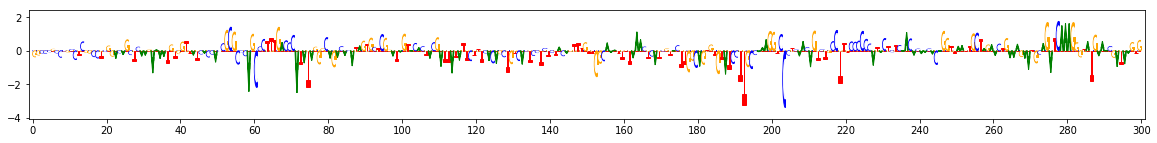

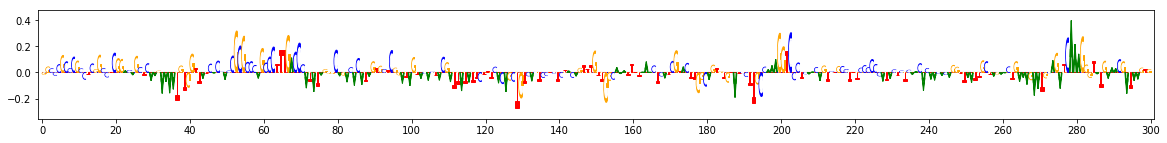

In [24]:
model_id = "record_1_model_Ba1Th"
f = h5py.File("imp_scores/imp_scores_"+model_id+".h5", "r")
onehot = f["onehot"]
ism_scores = f["scores_ism"]
deeplift_rescale_scores = f['scores_deeplift_rescale_dinucshuff']
ig_scores = f['scores_integrated_grad20_dinucshuff']

from deeplift.visualization import viz_sequence
print(motif_to_hit_locations['NR1H2:M6383_1.02'][74])
idx = motif_to_hit_locations['NR1H2:M6383_1.02'][74][0]
print(positives_seqs[idx][350:650])
viz_sequence.plot_weights((onehot[idx]*ism_scores[idx][:,None])[350:650],
                          subticks_frequency=20)
viz_sequence.plot_weights((onehot[idx]*deeplift_rescale_scores[idx][:,None])[350:650],
                          subticks_frequency=20)


In [26]:
#['CREB3:M5323_1.02', 'HNF4A:M4698_1.02', 'HNF4G:M2286_1.02', 'DMBX1:M5345_1.02', 'FOXA2:M4567_1.02', 'HNF1A:M6281_1.02', 'XBP1:M6536_1.02', 'NR2F1:M6176_1.02', 'RXRG:M6462_1.02', 'NR1H2:M6383_1.02', 'HIF1A:M6275_1.02']

for selected_motif in ['HNF4A:M4698_1.02',
                       'HNF4G:M2286_1.02',
                       'NR2F1:M6176_1.02',
                       'FOXA2:M4567_1.02',
                       'RXRG:M6462_1.02',
                       'HNF1A:M6281_1.02',
                       'HNF1B:M6282_1.02',
                       'NR1H2:M6383_1.02',
                       'CREB3:M5323_1.02',
                       'HIF1A:M6275_1.02',
                       'XBP1:M6536_1.02',
                       'DMBX1:M5345_1.02'
                      ]:
    print(selected_motif)
    for scoring_method in scoring_methods:
        print(scoring_method,
              np.mean(model_id_to_scoring_method_to_motif_to_ranks["average"][scoring_method][selected_motif]))
        #print(scoring_method,model_id_to_scoring_method_to_motif_to_auprcoverbg
        #         ["max"][scoring_method][selected_motif])
    #for scoring_method in scoring_methods:
    #    print(scoring_method)
    #    for model_id in ["average"]+model_ids:
    #        print(model_id_to_scoring_method_to_motif_to_auprcoverbg
    #              [model_id][scoring_method][selected_motif])

HNF4A:M4698_1.02
scores_ism 0.9620586203874283
scores_deeplift_rescale_dinucshuff 0.9910782828293417
scores_deeplift_genomicsdefault_dinucshuff 0.9893602986164958
scores_integrated_grad20_dinucshuff 0.979826612211623
scores_grad_times_inp_flatref 0.985300367315735
scores_integrated_grad20_avgposref 0.97862670296071
scores_deeplift_rescale_avgposref 0.9841973717152207
scores_deeplift_genomicsdefault_avgposref 0.9852306280683907
scores_integrated_grad20_flatref 0.9759176917525269
scores_deeplift_rescale_flatref 0.9727473027937217
scores_deeplift_genomicsdefault_flatref 0.9788438046344939
scores_integrated_grad10_dinucshuff 0.9791466230981587
scores_integrated_grad2_dinucshuff 0.9677106446078729
scores_integrated_grad5_dinucshuff 0.9677106446078729
HNF4G:M2286_1.02
scores_ism 0.9676231989190321
scores_deeplift_rescale_dinucshuff 0.9915166244786092
scores_deeplift_genomicsdefault_dinucshuff 0.9907039828761612
scores_integrated_grad20_dinucshuff 0.9858754298626737
scores_grad_times_inp_flat

In [25]:
sorted([(x,len(y)) for x,y in motif_to_hit_locations.items()],
        key=lambda x: -x[1])
[x[0] for x in sorted([(x,len(y)) for x,y in motif_to_hit_locations.items()],
        key=lambda x: -x[1])]

['HNF4A:M4698_1.02',
 'HNF4G:M2286_1.02',
 'NR2F1:M6176_1.02',
 'FOXA2:M4567_1.02',
 'RXRG:M6462_1.02',
 'HNF1A:M6281_1.02',
 'HNF1B:M6282_1.02',
 'NR1H2:M6383_1.02',
 'CREB3:M5323_1.02',
 'HIF1A:M6275_1.02',
 'XBP1:M6536_1.02',
 'DMBX1:M5345_1.02']

In [ ]:
#HNF4A:M4698_1.02
#NR2F1:M6176_1.02 is similar to HNF

In [ ]:
['CREB3:M5323_1.02', 'HNF1B:M6282_1.02', 'HNF4A:M4698_1.02', 'HNF4G:M2286_1.02', 'DMBX1:M5345_1.02', 'FOXA2:M4567_1.02', 'HNF1A:M6281_1.02', 'XBP1:M6536_1.02', 'NR2F1:M6176_1.02', 'RXRG:M6462_1.02', 'NR1H2:M6383_1.02', 'HIF1A:M6275_1.02', '(SP5)_(Drosophila_melanogaster)_(DBD_0.93):M5209_1.02', 'TCF7L1:M5903_1.02', 'NR2F6:M6392_1.02', '(KLF12)_(Mus_musculus)_(DBD_1.00):M0443_1.02', '(KLF7)_(Mus_musculus)_(DBD_1.00):M0405_1.02', '(ZFP161)_(Mus_musculus)_(DBD_1.00):M0432_1.02', 'NR6A1:M6397_1.02', 'E2F4:M4537_1.02']